In [1]:
from pauli_funct import *

# Liouvillian graph
Christopher White's paper: arXiv:2108.00019v2 has the most detailed explanations of these, including the meaning of the vertices and edges etc inside the graph. \

Keep in mind that these graphs are DIFFERENT from the graphs described in the PauliArray documentation, as shown here: https://algolab-quantique.github.io/pauliarray/tutorials/commutators.html. The graphs in this documentation refer to qubit nodes with edge interactions.

Start off with an example dipole Hamiltonian and an initial Pauli string, called "padded_seed"

In [2]:
seed_str = 'X'
pad_width = 2
padded_seed = 'I'*pad_width + seed_str + 'I'*pad_width      # So something like IIIIIXIIIII
n = len(padded_seed)        # total number of qubits

ham = generate_dipole_hamiltonian(n=n)

When the initial (t=0) Pauli string evolves in time (Heisenberg picture, operators evolve) via the Liouville equation, what happens is that it will become some new Pauli string. This new Pauli string, can be decomposed into more Pauli strings using equation (14) of White's paper. 

So each time step, the Pauli string will go from one node to another with some weight (see equation (14)); if we were to sum up the weights and the destination Pauli strings, we would acquire the total new Pauli string. 

The trace of (sigma^mu * Comm(sigma^nu, Hamiltonian)) is known as the Hilbert Schmidt inner product. This inner product gives (something proportional to) the weight of the component of the evolution into each new Pauli string, as determined by the Liouvillian superoperator, as seen in equation (16) of White's paper.

In [3]:
### Test Louiville graph with a bunch of print functions
graph, label_map = generate_louivillian_graph(seed_label=padded_seed, ham=ham, depth=2, max_nodes=1000)

Note that the printouts from inspect are based on little-endian counting (most significant qubit to least significant qubit)

Now time to visualise this as a graph!

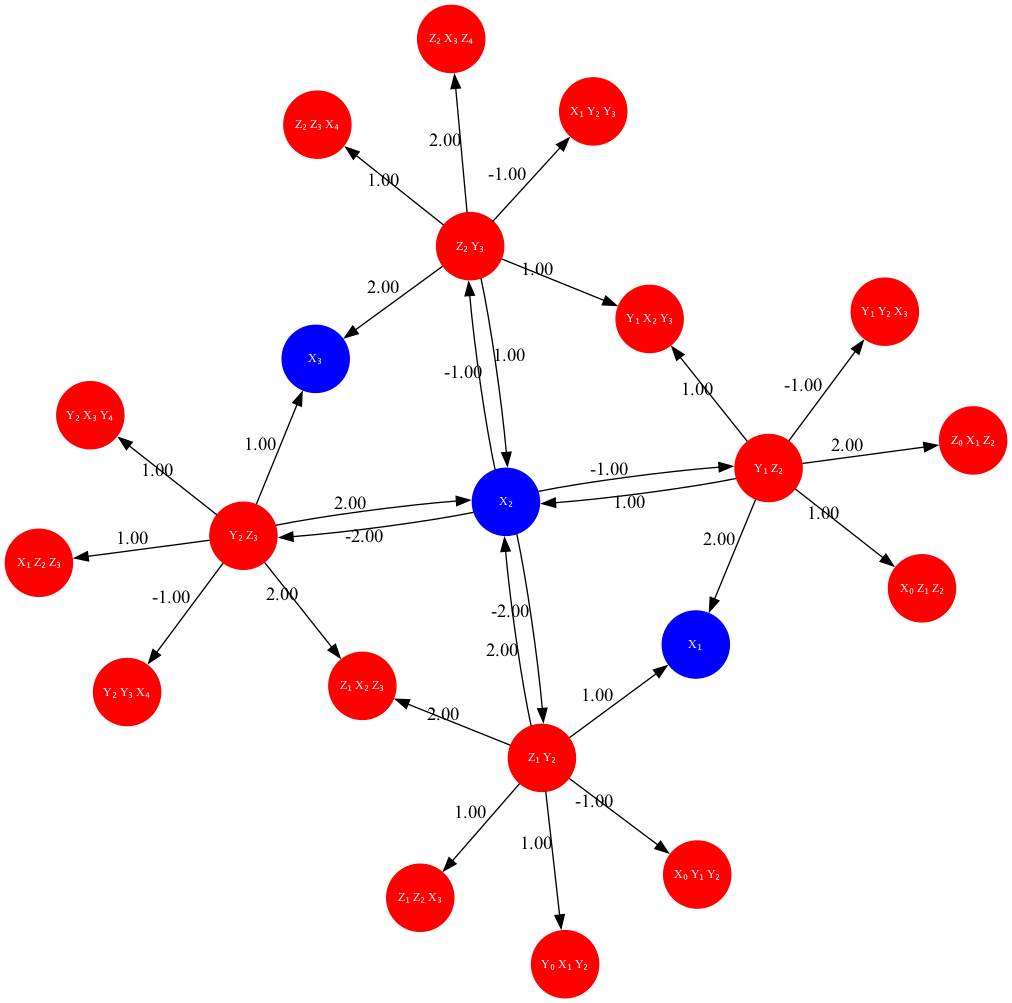

In [4]:
graphviz_draw(graph, node_attr_fn=node_attr, edge_attr_fn=edge_attr, method='sfdp')

Create an adjacency matrix for this graph.   
Note that @ is the matrix multiplication operator in Python!

In [5]:
chain_mat = rx.adjacency_matrix(graph, weight_fn= lambda x: x).T        # Create the Liouville graph's associated adjacency matrix; easy for rustworks to do

# Example usage with the notebook's variables:
n = chain_mat.shape[0]      # rows of the adjacency matrix
A0 = np.zeros(n)            # Just create 
A0[0] = 1.0                 # set initial occupancy on the root node (root_idx exists in the notebook)

times = np.linspace(0.0, 10.0, 100)  # adjust as needed

A_t = solve_chain_time_series(chain_mat, A0, times, max_step=0.001)

# print a small summary
print("A(t) shape:", A_t.shape)
print("A(0) :", A_t[0])     # confirms that A_t[0] == A0 as we wanted

A(t) shape: (100, 21)
A(0) : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Make another graph 
Using a new Hamiltonian and new initial Pauli string, repeat the exact same process

In [6]:
seed_str = 'Z'
pad_width = 15
padded_seed = 'I'*pad_width + seed_str + 'I'*pad_width
ham2 = generate_dipole_hamiltonian(len(padded_seed))
root_idx = 0  # since seed is the first node added
graph_2, label_map_2 = generate_louivillian_graph(padded_seed, ham2, depth=4, corr_cutoff=3, max_nodes=100000, directed=True)


chain_mat_2 =  rx.adjacency_matrix(graph_2, weight_fn= lambda x: x).T

# Example usage with the notebook's variables:
n = chain_mat_2.shape[0]
A0 = np.zeros(n)
print(chain_mat_2)
A0[0] = 1.0     # set initial occupancy on the root node (root_idx exists in the notebook)

times = np.linspace(0.0, 10.0, 100)  # adjust as needed
A_t = solve_chain_time_series(chain_mat_2, A0, times,max_step=0.001)

# print a small summary
print("A(t) shape:", A_t.shape)
print("A(0) :", A_t[0])     # initial adjacency matrix at 0 time

[[ 0. -1.  1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [-1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
A(t) shape: (100, 69)
A(0) : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


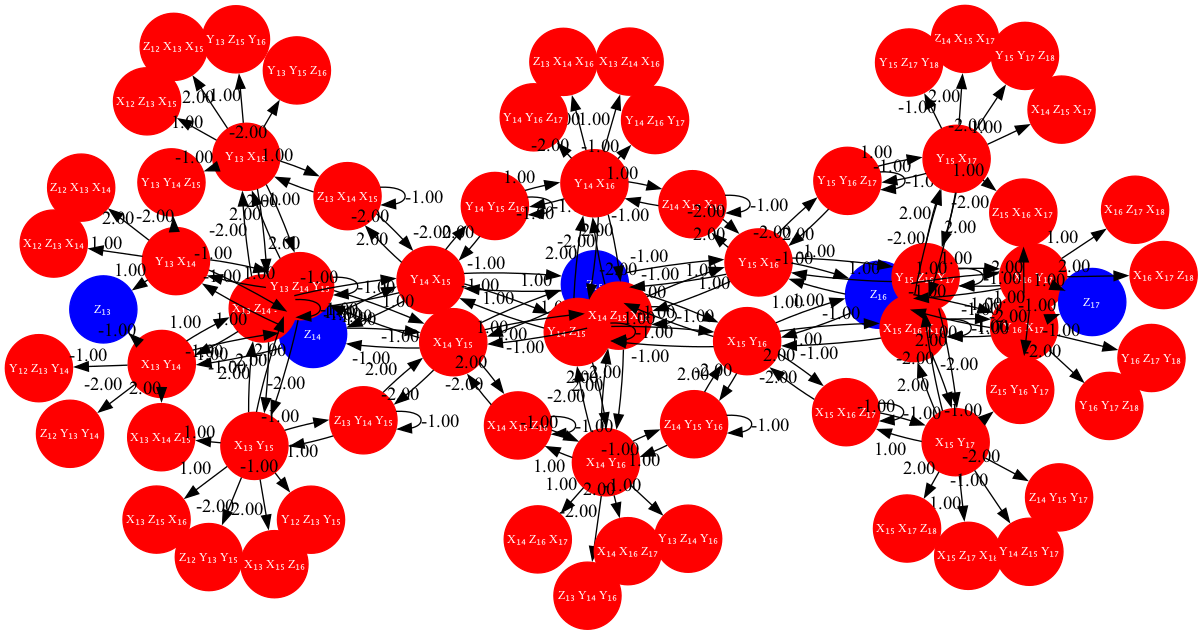

In [7]:
graphviz_draw(graph_2, node_attr_fn=node_attr, edge_attr_fn=edge_attr, method='sfdp')

# New territory with the second graph
Plotting the amplitude of the single Z Pauli strings

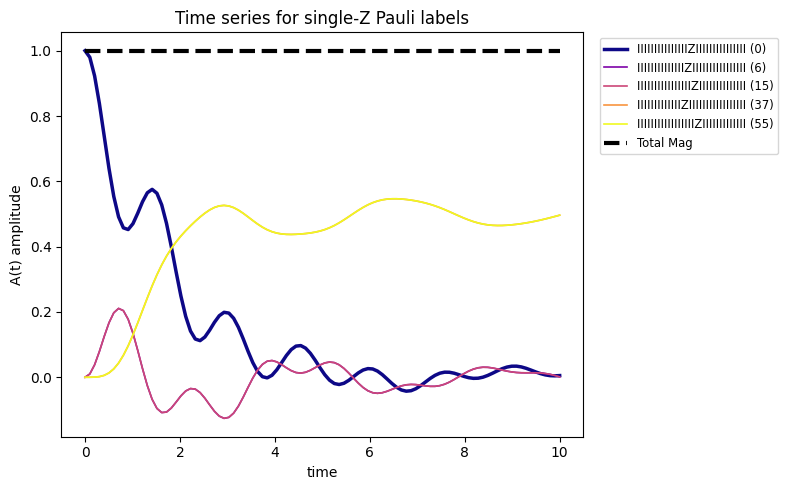

In [8]:
# Filter for labels with exactly one 'Z'
zi_items = [(lab, idx) for lab, idx in label_map_2.items() if set(lab) <= {"I", "Z"}]       # Only if the label contains I's and Z's
single_z_items = [(lab, idx) for lab, idx in zi_items if lab.count('Z') == 1]               # within those that are only I's and Z's, consider those with only one Z

if not single_z_items:
    print("No single-Z labels found in zi_items.")
    
else:
    # Sort by node index for stable ordering
    single_z_items = sorted(single_z_items, key=lambda x: x[1])

    labels = [lab for lab, _ in single_z_items]
    idxs = [idx for _, idx in single_z_items]

    total_z = np.zeros(len(times))

    plt.figure(figsize=(8, 5))

    cmap = plt.get_cmap("plasma")

    for k, (lab, idx) in enumerate(zip(labels, idxs)):
        color = cmap(k / max(1, len(labels) - 1))       # create a "colour gradient" using this cmap
        lw = 2.5 if idx == root_idx else 1.2            # define some linewidth
        total_z += A_t[:, idx]                          # The entire column of index idx in adjacency matrix A_t; 
        # this column corresponds to the connections of the single z pauli string of the iteration on the Liouville graph
        
        plt.plot(times, A_t[:, idx], label=f"{lab} ({idx})", color=color, linewidth=lw)     # plotting that particular column over all time. The index tells you the column it's in in the adjacency matrix

    plt.plot(times, total_z, label="Total Mag", color="black", linewidth=3, linestyle="--")
    plt.xlabel("time")
    plt.ylabel("A(t) amplitude")
    plt.title("Time series for single-Z Pauli labels")
    plt.legend(fontsize="small", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

### Multiple quantum coherence

See https://tinyurl.com/zwvct98m for the proper definition of multiple quantum coherence. It has everything to do with raising and lowering operators; the NET effect of their raising and lowering is what defines the "quantum coherence order".

In [16]:
# Testing out pauli_to_mqc function

p_string2="IXXYIXZXYYYXYXYYXYXXZYYXXYXZYXYXYXYXYXYXYXYXYYXYXYXYXYXYYYXYXYXYXYXXYXYX"
p_string = "XYXZX"
num_x = p_string.count('X')
num_y = p_string.count('Y')

mqc_result = pauli_to_mqc(p_string=p_string)

# ========================================================================
# NOTE: original, sympy attempt: more "accurate" but slower

sigmaplus = sympy.symbols("sigmaplus")
sigmaminus = sympy.symbols("sigmaminus")

expression = (sigmaminus + sigmaplus)**num_x * (sigmaminus - sigmaplus)**num_y
print(expression.expand())
print()

mqccompare = {}

for term in expression.expand().args:

    coefficient, sigmaterms = term.as_coeff_Mul()
    
    power_dict = sigmaterms.as_powers_dict()
    
    plusterms = power_dict.get(sigmaplus, 0)
    minusterms = power_dict.get(sigmaminus, 0)
    
    q = plusterms - minusterms

    mqccompare[q] = int(coefficient)*(1j)**num_y       # throw the imaginary unit back in because we neglected it earlier.

print(mqc_result)
print()
print(mqccompare)
print()
print(mqc_result == mqccompare)

print(mqc_result.keys() == mqccompare.keys())



sigmaminus**4 + 2*sigmaminus**3*sigmaplus - 2*sigmaminus*sigmaplus**3 - sigmaplus**4

{-4: 1j, -2: 2j, 2: -2j, 4: -1j}

{-4: 1j, 4: (-0-1j), 2: (-0-2j), -2: 2j}

True
True


In [ ]:
# Compute MQC intensities
mqc_intensity = {}

for label, idx in label_map_2.items():

    mqc_orders = pauli_to_mqc(label)        # For each and every Pauli string, create the dictionary of MQC orders

    for order, coeff in mqc_orders.items():

        if order not in mqc_intensity:
            mqc_intensity[order] = np.zeros(len(times),dtype=np.complex128)

        mqc_intensity[order] += coeff * A_t[:, idx]

mqc_intensity = {order: np.abs(intensity)**2 for order, intensity in mqc_intensity.items()}
# Create a 3D wire plot for MQC intensities

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

orders = sorted(mqc_intensity.keys())
X, Y = np.meshgrid(times, orders)
Z = np.array([mqc_intensity[order] for order in orders])

for i in range(len(orders)):
    ax.plot(times, [orders[i]] * len(times), Z[i], label=f"Order {orders[i]}")

ax.set_xlabel("Time")
ax.set_ylabel("MQC Order")
ax.set_zlabel("Intensity")
ax.set_title("3D Wire Plot of MQC Intensities")
plt.legend(fontsize="small", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
plot_mqc_from_label_map(label_map_2, A_t, times)

# Third graph, different Hamiltonian
Using the double quantum hamiltonian. Then repeat all actions as above

In [ ]:
pad=15
padded_seed = 'I'*pad + 'Z' + 'I'*pad

dq = generate_dq_hamiltonian(len(padded_seed))
graph_dq, label_map_dq = generate_louivillian_graph(padded_seed, dq, depth=len(padded_seed)*2, corr_cutoff=len(padded_seed), max_nodes=100000, directed=True)    

A0 = np.zeros(len(label_map_dq))
A0[0] = 1.0  # initial occupancy on root node
times = np.linspace(0.0, 5.0, 500)  

# Generate the adjacency matrix using rustworkx
chain_mat = rx.adjacency_matrix(graph_dq, weight_fn=lambda x: x).T

# Solve the time evolution using the solve_chain_time_series function
A_t = solve_chain_time_series(chain_mat, A0, times, max_step=0.01)

In [ ]:
graphviz_draw(graph_dq, node_attr_fn=node_attr, edge_attr_fn=edge_attr, method='sfdp')

In [ ]:
# Filter for labels with exactly one 'Z' and the rest 'I's
single_z_items = [(lab, idx) for lab, idx in label_map_dq.items() if set(lab) <= {"I", "Z"} and lab.count('Z') == 1]

if not single_z_items:
    print("No single-Z labels found in label_map_dq.")
else:
    # Extract indices for the relevant nodes
    idxs = [idx for _, idx in single_z_items]

    # Compute the sum of the corresponding terms in A_t
    total_single_z = np.sum(A_t[:, idxs], axis=1)

    # Plot the result
    plt.figure(figsize=(8, 5))
    plt.plot(times, total_single_z, label="Sum of Single-Z Terms", color="blue", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Sum of Single-Z Terms Over Time")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Bessel function
Why?

In [ ]:
# Define the Bessel function model
def bessel_model(t, amplitude, frequency, phase):
    return amplitude * j0(2 * np.pi * frequency * t + phase)

# Perform the curve fitting
initial_guess = [1.0, 1.25, 0.0]  # Initial guesses for amplitude, frequency, and phase
params, covariance = curve_fit(bessel_model, times, total_single_z, p0=initial_guess)

# Extract the fitted parameters
amplitude_fit, frequency_fit, phase_fit = params
print(f"Fitted parameters: Amplitude = {amplitude_fit}, Frequency = {frequency_fit}, Phase = {phase_fit}")

# Generate the fitted curve
fitted_curve = bessel_model(times, amplitude_fit, frequency_fit, phase_fit)

# Plot the original data and the fitted curve
plt.figure(figsize=(8, 5))
plt.plot(times, total_single_z, label="Total Single-Z (Data)", color="blue", linewidth=2)
plt.plot(times, fitted_curve, label="Fitted Bessel Function", color="red", linestyle="--", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Fit of Total Single-Z to a Bessel Function")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plot_mqc_from_label_map(label_map_dq, A_t, times)

# More graphs (redundant, hidden)

In [ ]:
# graph_3, label_map_3 = generate_louivillian_graph(padded_seed, ham, depth=10, corr_cutoff=4, max_nodes=1000, directed=True)
# #graphviz_draw(graph_3, node_attr_fn=node_attr, edge_attr_fn=edge_attr, method='sfdp')

In [ ]:
# chain_mat_3 =  rx.adjacency_matrix(graph_3,weight_fn= lambda x: x).T
# # Example usage with the notebook's variables:
# n = chain_mat_3.shape[0]
# A0 = np.zeros(n)
# # set initial occupancy on the root node (root_idx exists in the notebook)
# A0[0] = 1.0

# times = np.linspace(0.0, 10.0, 100)  # adjust as needed
# A_t = solve_chain_time_series(chain_mat_3, A0, times,max_step=0.001)

In [ ]:
# # Filter for labels with exactly one 'Z'
# zi_items = [(lab, idx) for lab, idx in label_map_3.items() if set(lab) <= {"I", "Z"}]
# single_z_items = [(lab, idx) for lab, idx in zi_items if lab.count('Z') == 1]

# if not single_z_items:
#     print("No single-Z labels found in zi_items.")
# else:
#     # Sort by node index for stable ordering
#     single_z_items = sorted(single_z_items, key=lambda x: x[1])
#     labels = [lab for lab, _ in single_z_items]
#     idxs = [idx for _, idx in single_z_items]

#     total_z = np.zeros(len(times))
#     plt.figure(figsize=(8, 5))
#     cmap = plt.get_cmap("plasma")
#     for k, (lab, idx) in enumerate(zip(labels, idxs)):
#         color = cmap(k / max(1, len(labels) - 1))
#         lw = 2.5 if idx == root_idx else 1.2
#         total_z += A_t[:, idx]
#         plt.plot(times, A_t[:, idx], label=f"{lab} ({idx})", color=color, linewidth=lw)

#     plt.plot(times, total_z, label="Total Mag", color="black", linewidth=3, linestyle="--")
#     plt.xlabel("time")
#     plt.ylabel("A(t) amplitude")
#     plt.title("Time series for single-Z Pauli labels")
#     plt.legend(fontsize="small", bbox_to_anchor=(1.02, 1), loc="upper left")
#     plt.tight_layout()
#     plt.show()

In [ ]:
# graph_4, label_map_4 = generate_louivillian_graph(padded_seed, ham, depth=10, corr_cutoff=5, max_nodes=1000, directed=True)

In [ ]:
# chain_mat_4 =  rx.adjacency_matrix(graph_4,weight_fn= lambda x: x).T
# # Example usage with the notebook's variables:
# n = chain_mat_4.shape[0]
# A0 = np.zeros(n)
# # set initial occupancy on the root node (root_idx exists in the notebook)
# A0[0] = 1.0

# times = np.linspace(0.0, 10.0, 100)  # adjust as needed
# A_t = solve_chain_time_series(chain_mat_4, A0, times,max_step=0.001)

In [ ]:
# # Filter for labels with exactly one 'Z'
# zi_items = [(lab, idx) for lab, idx in label_map_4.items() if set(lab) <= {"I", "Z"}]
# single_z_items = [(lab, idx) for lab, idx in zi_items if lab.count('Z') == 1]

# if not single_z_items:
#     print("No single-Z labels found in zi_items.")
# else:
#     # Sort by node index for stable ordering
#     single_z_items = sorted(single_z_items, key=lambda x: x[1])
#     labels = [lab for lab, _ in single_z_items]
#     idxs = [idx for _, idx in single_z_items]

#     total_z = np.zeros(len(times))
#     plt.figure(figsize=(8, 5))
#     cmap = plt.get_cmap("plasma")
#     for k, (lab, idx) in enumerate(zip(labels, idxs)):
#         color = cmap(k / max(1, len(labels) - 1))
#         lw = 2.5 if idx == root_idx else 1.2
#         total_z += A_t[:, idx]
#         plt.plot(times, A_t[:, idx], label=f"{lab} ({idx})", color=color, linewidth=lw)

#     plt.plot(times, total_z, label="Total Mag", color="black", linewidth=3, linestyle="--")
#     plt.xlabel("time")
#     plt.ylabel("A(t) amplitude")
#     plt.title("Time series for single-Z Pauli labels")
#     plt.legend(fontsize="small", bbox_to_anchor=(1.02, 1), loc="upper left")
#     plt.tight_layout()
#     plt.show()

In [ ]:
# p_string="IXXYIXZXYYYX"
# num_x = p_string.count('X')
# num_y = p_string.count('Y')

# # Alternative (possibly more efficient) term wise multiplication
# # Each term in the term wise mult is comb(num_x , k)*sigmaminus ^ (numx-k) * sigmaplus ^ k * comb(num_x , g)*sigmaminus ^ (numx-g) * sigmaplus ^ g * (-1)^g (the sign from the Y's)
# # simplify algebraically by hand and solve here with nested for loop

# mqc = {}

# for k in range(0, num_x+1):
#     for g in range(0, num_y+1):
#         q = int(2*(k+g)-num_y-num_x)
#         mqc[q] = mqc.get(q,0) + int((-1)**g * comb(num_x,k,exact=True) * comb(num_y,g,exact=True))*(1j)**num_y

# print(mqc)

# print(mqc==mqc_result)